In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [2]:
if torch.cuda.is_available():
    device = 'cuda' 
elif torch.backends.mps.is_available():
    device = 'mps'   
else:
    device = 'cpu'  

dataset_path = 'APS360_Project_Dataset/dataset4_preprocessed_augmented'

def load_images_for_dataset4(base_path):
    images = []
    labels = []
    
    for label in os.listdir(base_path):
        folder_path = os.path.join(base_path, label)
        
        if os.path.isdir(folder_path):
            for img_file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_file)
                image = cv2.imread(img_path)
                
                if image is not None:
                    images.append(image) 
                    labels.append(int(label))  # Folder name is the label (0-9)
                else:
                    print(f"Warning: Failed to load image {img_path}")
    
    return images, labels

def split_data(images, labels, test_size=0.1, val_size=0.2, random_state=42):
    train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=test_size, random_state=random_state)
    train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=val_size, random_state=random_state)
    return train_images, train_labels, val_images, val_labels, test_images, test_labels


In [3]:
class DigitDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
         # Convert image to float32 and normalize to [0, 1]
        if image.dtype != np.float32:
            image = image.astype(np.float32) / 255.0
        
        # If grayscale, convert to a single channel
        if image.shape[-1] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Convert to tensor
        image = torch.tensor(image).unsqueeze(0)  # Add channel dimension for grayscale (1, H, W)
        label = torch.tensor(label, dtype=torch.long)
        return image, label
    
def create_dataloaders(batch_size, train_images, train_labels, val_images, val_labels, test_images, test_labels):
    # Create Dataset instances
    train_dataset = DigitDataset(train_images, train_labels)
    val_dataset = DigitDataset(val_images, val_labels)
    test_dataset = DigitDataset(test_images, test_labels)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [4]:
images, labels = load_images_for_dataset4(dataset_path)

train_images, train_labels, val_images, val_labels, test_images, test_labels = split_data(images, labels)

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class DigitCNN(nn.Module):
    def __init__(self):
        super(DigitCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=2),
            nn.BatchNorm2d(32, momentum=0.1)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=2),
            nn.BatchNorm2d(64, momentum=0.1)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=2),
            nn.BatchNorm2d(128, momentum=0.1)
        )
        self.fc1 = nn.Linear(128 * 29 * 29, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 10)  # 10 classes for digits 0-9
        self

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 128 * 29 * 29)
        x = F.relu(self.dropout(self.fc1(x)))
        x = self.fc2(x)
        return x


In [6]:
import matplotlib.pyplot as plt

def train_model(model, criterion, learning_rate, train_loader, val_loader, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        # if epoch % 10 == 0:
        #     learning_rate = learning_rate / 10

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * images.size(0)

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_loader.dataset)
        val_acc = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%")

    # Plotting training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.show()

def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_acc = 100 * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")

Using device: cuda


c:\Users\Lione\miniconda3\envs\APS360\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 2.2707, Validation Loss: 2.2833, Train Accuracy: 16.33%, Validation Accuracy: 11.11%
Epoch 2/50, Train Loss: 2.1076, Validation Loss: 2.2298, Train Accuracy: 27.68%, Validation Accuracy: 13.06%
Epoch 3/50, Train Loss: 1.9924, Validation Loss: 2.0061, Train Accuracy: 34.31%, Validation Accuracy: 40.35%
Epoch 4/50, Train Loss: 1.7989, Validation Loss: 1.8486, Train Accuracy: 43.42%, Validation Accuracy: 40.94%
Epoch 5/50, Train Loss: 1.7209, Validation Loss: 1.6308, Train Accuracy: 46.59%, Validation Accuracy: 54.58%
Epoch 6/50, Train Loss: 1.5450, Validation Loss: 1.5733, Train Accuracy: 55.70%, Validation Accuracy: 54.00%
Epoch 7/50, Train Loss: 1.4216, Validation Loss: 1.4444, Train Accuracy: 62.28%, Validation Accuracy: 60.62%
Epoch 8/50, Train Loss: 1.3013, Validation Loss: 1.3392, Train Accuracy: 68.32%, Validation Accuracy: 68.03%
Epoch 9/50, Train Loss: 1.1861, Validation Loss: 1.2551, Train Accuracy: 74.46%, Validation Accuracy: 75.24%
Epoch 10/50, Train 

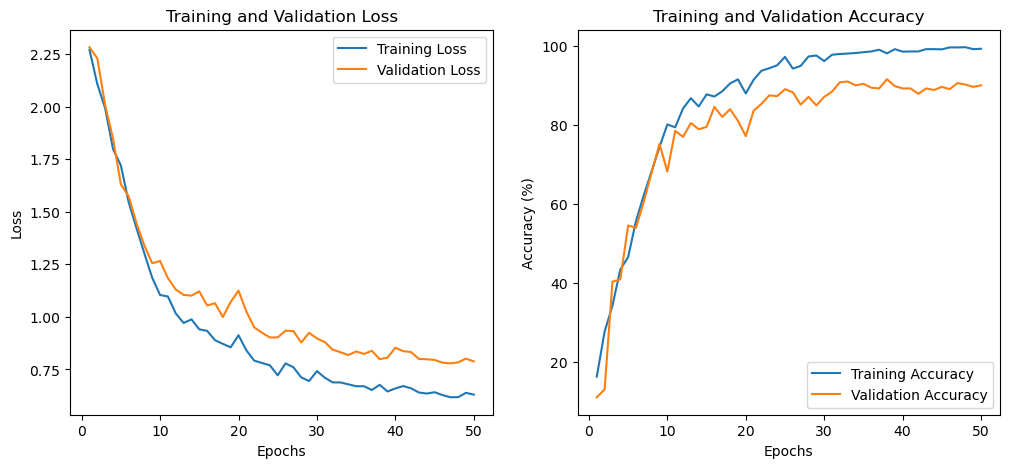

In [10]:
model = DigitCNN().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
learning_rate = 0.001

batch_size = 128
train_loader, val_loader, test_loader = create_dataloaders(batch_size, train_images, train_labels, val_images, val_labels, test_images, test_labels)

# Train the model
train_model(model, criterion, learning_rate, train_loader, val_loader, num_epochs=50)

In [9]:
torch.save(model.state_dict(), "CNN_bs128_lr0.001_SGD_94valacc.pth")
test_model(model, test_loader)

Test Accuracy: 88.77%
